## This Notebook

<a href="https://colab.research.google.com/github/OSA7JIMI/SC3000/blob/main/ezra0004_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Original Q-Table 
#### The link to the training run which generated the original q-table is attached here
<a href="https://colab.research.google.com/github/OSA7JIMI/SC3000/blob/main/best_qtable_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Original Q-Table"/></a>

## Installing dependencies:

This cell has no output because I commented it out during Google Colab runtime as all the dependencies were already installed.

In [6]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Import dependencies, define helper functions, initialise environment

In [7]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

env = gym.make("CartPole-v1")

## Task 1: Development of an RL agent

A Q-learning agent is applied in this task. To obtain the Q-table, an epsilon-greedy strategy with exploration rate of 0.1 was used to choose actions.

The Q-values were calculated using the formula given in the lecture slides: new estimation = old estimation + learning rate(new sample - old estimation). The learning rate is set at 0.1 and the discount value at 0.9.

After the Q-table has been populated, the agent returns the optimal action directly from the table without any randomness.

In [8]:
def table_agent(state):
    if random.random()< 0.1:
        return random.randint(0,1)
    else:
        return np.argmax(q_table[state])

def update_table(state, action, reward, future):
    best = np.argmax(q_table[future])
    target = reward + 0.9*q_table[future, best]
    error = target - q_table[state, action]
    q_table[state, action] += 0.1*error

def test_agent(state):
    return np.argmax(q_table[state])

### Observation-to-state conversion

Since the original observation is an array containing continuous values, it must first be converted into a discrete state. A total of 20 states were used to represent observations. States 0-15 are used to represent the binary values of whether each element of the observation is more than 0.

As initial observations showed that the most common termination reason was the cart travelling out of the screen, extreme values of position and velocity must be accounted for. States 16-19 represent these danger zones. Since the event of the pendulum swinging more than 12 degrees was rarely observed, states were not allocated to represent this danger.

The order of the return statements is arranged from highest to lowest priority, starting with dangerous position, then dangerous velocity, then the observations in binary.

In [9]:
def tuning_converter(observation, pos_proportion, v_proportion):
    if observation[0] > 2.4*pos_proportion:
        return 16
    if observation[0] < -2.4*pos_proportion:
        return 17
    if observation[1] > 4*v_proportion:
        return 18
    if observation[1] < -4*v_proportion:
        return 19

    pos = observation[0] > 0
    v = observation[1] > 0
    ang = observation[2] > 0
    av = observation[3] > 0
    state = pos*8 + v*4 + ang*2 + av
    return state

### Training the agent and tuning hyperparameters

Danger zones are important hyperparameters of the model. In order to define them optimally, fine tuning must be performed.

From environment rules and initial observations, the maximum position is set at +/- 2.4 and the maximum velocity is set at +/- 4. 4 proportions (75%, 80%, 85%, 90%) are tested by populating the Q-table with 100 sets of 100 episodes and testing it on another 10 sets of 100 episodes.

The mean reward for each test set of episodes is calculated and the proportions with the highest minimum mean reward are taken as the optimal hyperparameters. The minimum mean was chosen for comparison because it provides confidence that the Q-table is decent even in the worst case scenario.

In [10]:
best_min = 0
best_p = 0
best_v = 0
best_q = np.zeros((20,2))

for p in [0.75, 0.8, 0.85, 0.9]:
    for v in [0.75, 0.8, 0.85, 0.9]:
        q_table = np.zeros((20,2))

        for i in range(100):
            for j in range(100):
                observation = env.reset()
                cumulative_reward = 0
                done = False
                while not done:
                    state = tuning_converter(observation, p, v)
                    action = table_agent(state)
                    observation, reward, done, info = env.step(action)
                    future = tuning_converter(observation, p, v)
                    cumulative_reward += reward
                    update_table(state, action, cumulative_reward, future)

        episode_means = []
        for i in range(10):
            episode_results = np.array([])
            for j in range(100):
                observation = env.reset()
                cumulative_reward = 0
                done = False
                while not done:
                    state = tuning_converter(observation, p, v)
                    action = test_agent(state)
                    observation, reward, done, info = env.step(action)
                    cumulative_reward += reward
                episode_results = np.append(episode_results,cumulative_reward)
            episode_means.append(episode_results.mean())

        if min(episode_means) > best_min:
            best_min = min(episode_means)
            best_p = p
            best_v = v
            best_q = q_table

        print(min(episode_means), p, v)

print()
print('Best Minimum Mean, Best P, Best V')
print(best_min, best_p, best_v)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


53.75 0.75 0.75
124.9 0.75 0.8
78.29 0.75 0.85
154.1 0.75 0.9
98.28 0.8 0.75
102.38 0.8 0.8
94.45 0.8 0.85
82.77 0.8 0.9
81.64 0.85 0.75
56.62 0.85 0.8
39.88 0.85 0.85
35.42 0.85 0.9
37.05 0.9 0.75
53.49 0.9 0.8
54.5 0.9 0.85
86.8 0.9 0.9

Best Minimum Mean, Best P, Best V
154.1 0.75 0.9


### When training an agent from scratch

Trackers are initialised to record the best Q-table and its hyperparameters.

#### Each time the notebook is opened, this cell should be commented out after the first run, else the records will keep resetting.

In [11]:
record_best_q = np.zeros((20,2))
record_best_min = 0
record_best_p = 0
record_best_v = 0

### When using my trained agent
This cell will nullify the effect of the previous cell.

It records the best performing Q-table that I found during training, with a minimum mean reward of 294.17 and both hyperparameters at 75%.

#### To use an agent that is trained from scratch, comment this cell out.

In [12]:
record_best_q = np.array([[1451.62611697,  514.99617382],
           [1709.009941  , 1029.21087411],
           [ 760.79884463, 1808.22820041],
           [ 932.22331732, 1689.31355644],
           [ 913.63429623,  511.15432976],
           [ 447.45660861,  543.8179625 ],
           [1543.73110411, 1377.84295539],
           [1152.96659858, 1489.90443688],
           [1191.21247374,  932.11745667],
           [ 870.59754528, 1125.51501821],
           [ 525.96247204,  638.06132196],
           [ 485.05456479,  571.58755071],
           [1085.83328508,  766.35809815],
           [ 986.39948536,  516.99516015],
           [ 579.78793808,  994.54769863],
           [ 594.55726208,  790.79385194],
           [1689.897476  , 1690.28153047],
           [1828.79840885, 1733.33424038],
           [ 183.6541616 ,    0.        ],
           [  58.5198753 ,    0.        ]])

record_best_min = 294.17
record_best_p = 0.75
record_best_v = 0.75

### Updating records

The Q-table and hyperparameters are set to optimal values. In some training sessions, the Q-values for dangerous velocity (state 18-19) are still 0. This indicates that the agent has not learned enough about these states to assign them values.

The hyperparameters and Q-table can be improved by running the notebook multiple times.

In [13]:
if record_best_min >= best_min:
    q_table = record_best_q
    print('No change to Q-table')
    print()

else:
    q_table = best_q
    record_best_q = q_table
    record_best_min = best_min
    record_best_p = best_p
    record_best_v = best_v
    print('New best Q-table')
    print()

q_table

No change to Q-table



array([[1451.62611697,  514.99617382],
       [1709.009941  , 1029.21087411],
       [ 760.79884463, 1808.22820041],
       [ 932.22331732, 1689.31355644],
       [ 913.63429623,  511.15432976],
       [ 447.45660861,  543.8179625 ],
       [1543.73110411, 1377.84295539],
       [1152.96659858, 1489.90443688],
       [1191.21247374,  932.11745667],
       [ 870.59754528, 1125.51501821],
       [ 525.96247204,  638.06132196],
       [ 485.05456479,  571.58755071],
       [1085.83328508,  766.35809815],
       [ 986.39948536,  516.99516015],
       [ 579.78793808,  994.54769863],
       [ 594.55726208,  790.79385194],
       [1689.897476  , 1690.28153047],
       [1828.79840885, 1733.33424038],
       [ 183.6541616 ,    0.        ],
       [  58.5198753 ,    0.        ]])

### Task 1 Deliverable

For Task 1, the observation and chosen action is shown below:

In [14]:
observation = env.reset()
state = tuning_converter(observation, record_best_p, record_best_v)
action = test_agent(state)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.0410416   0.01839801 -0.04203885  0.03827573]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, the agent developed in Task 1 played the game for 100 episodes. The cumulative reward for each episode was recorded and plotted on the graph.

In [15]:
episode_results = []
for i in range(100):
    observation = env.reset()
    cumulative_reward = 0
    done = False
    while not done:
        state = tuning_converter(observation, record_best_p, record_best_v)
        action = test_agent(state)
        observation, reward, done, info = env.step(action)
        cumulative_reward += reward
    episode_results.append(cumulative_reward)

The graph shows a good result with many instances of truncation (maximum cumulative reward = 500).

There are also a few instances of low cumulative reward (<100). These anomalies are likely due to one or two starting states that the agent needs more training on.

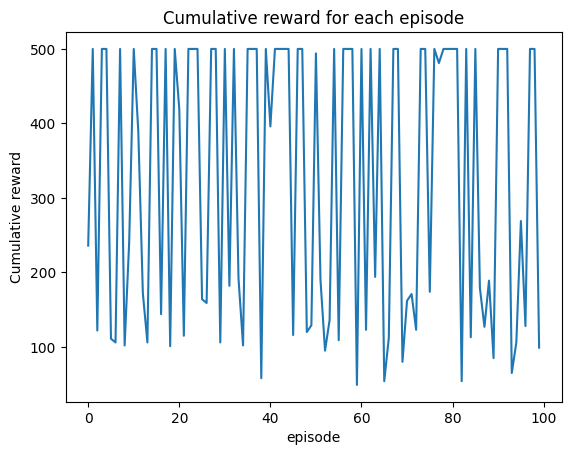

In [16]:
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

The average reward over the 100 episodes is significantly higher than required.

In [17]:
mean = sum(episode_results)/100
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 327.49
Is my agent good enough? True


## Task 3: Render one episode played by the agent

The video of an episode is displayed below. The cumulative reward is quite low.

As this is only one episode, it is not representative of the model.

In [18]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    state = tuning_converter(observation, record_best_p, record_best_v)
    action = test_agent(state)
    observation, reward, done, info = env.step(action)
    if done:
        break;
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
